In [1]:
import pandas as pd
import pylab as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function Definition

In [2]:
# The p_value is returned to verify Stationarity 
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [3]:
# Corelation and Differencing Plots (1 e 2).
def Differencing_Plot(df_value):  
    
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])

    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    axes[2, 0].plot(df_value.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df_value.diff().diff().dropna(), ax=axes[2, 1])

    fig.tight_layout()
    return plt.show()

In [4]:
def Model_Creation(parTrain, parMax_p, parMax_q, parSeasonal):
    model = auto_arima(   parTrain,
                          start_p = 0,
                          start_q = 0,
                          information_criterion = 'aic',
                          test = 'adf',
                          max_p = parMax_p,
                          max_q = parMax_q,
                          D = 1,
                          start_P = 0,
                          m = 12,
                          seasonal = parSeasonal,
                          trace = True,
                          error_action = "ignore",
                          suppress_warnings = True,
                          stepwise = True,
                          verbose = 1)
    return model.summary()

In [5]:
# Allows you to perform the study using SARIMAX
# Moreover a what if analysis between test data and prediction is introduced 
# A1: First element for the order of arima
# A2: Second element for the order of arima
# A3: Third element for the order of arima
# S1: First element for Sarima's order
# S2: Second element for Sarima's order
# S3: Third element for the order of Sarima

def Sarimax_Execution(parTrain,parTest,parColumn,parSteps,A1,A2,A3,S1,S2,S3,parSeason):
  
    # Model Built
    model = SARIMAX(parTrain, order=(A1,A2,A3), seasonal_order=(S1,S2,S3,parSeason))
    
    # Fitting model
    results = model.fit()
    
    # Plot parameters
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Prevision with Confidence Intervall
    forecast = results.get_forecast(steps = parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()

    return forecast

In [6]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Assumptions_Sondrio["SETTOREECONOMICO"])* train_size)

    # Split
    train = Assumptions_Sondrio.iloc[:split_idx]
    test = Assumptions_Sondrio.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

# Creation of the New DataSet for Time Series

In [7]:
Assumptions = pd.read_csv('Lavori_Attivati_Cleaning.csv')

In [8]:
Assumptions_Sondrio = Assumptions.copy()

In [9]:
Assumptions_Sondrio.head(5)

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,TIPO,NAZIONE,ANNO,SETTOREECONOMICO
0,2020-09-01,F,52,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,MILANO,ATTIVATO,PERU',2020,4
1,2021-10-06,M,51,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ROMANIA,2021,7
2,2021-06-11,F,35,Istruzione secondaria di primo grado: scuole m...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ITALIA,2021,8
3,2020-03-04,F,40,Istruzione secondaria di primo grado: scuole m...,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ATTIVATO,ITALIA,2020,8
4,2020-11-04,F,38,Istruzione secondaria di primo grado: scuole m...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ITALIA,2020,8


## Changing Columns Type

In [10]:
Assumptions_Sondrio['DATA'] = pd.to_datetime(Assumptions_Sondrio['DATA'])
Assumptions_Sondrio['SETTOREECONOMICO'] = pd.to_numeric(Assumptions_Sondrio['SETTOREECONOMICO'])

In [11]:
Assumptions_Sondrio.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [12]:
Assumptions_Sondrio.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,TIPO,NAZIONE,ANNO,SETTOREECONOMICO
0,2020-09-01,F,52,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,MILANO,ATTIVATO,PERU',2020,4
1,2021-10-06,M,51,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ROMANIA,2021,7
2,2021-06-11,F,35,Istruzione secondaria di primo grado: scuole m...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ITALIA,2021,8
3,2020-03-04,F,40,Istruzione secondaria di primo grado: scuole m...,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ATTIVATO,ITALIA,2020,8
4,2020-11-04,F,38,Istruzione secondaria di primo grado: scuole m...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ATTIVATO,ITALIA,2020,8


In [13]:
Assumptions_Sondrio.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

## Rebuilding of the DataSet

In [14]:
Assumptions_Sondrio = Assumptions_Sondrio[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Assumptions_Sondrio.head()

,DATA,SETTOREECONOMICODETTAGLIO,SETTOREECONOMICO,PROVINCIAIMPRESA
0,2020-09-01,Attività di famiglie e convivenze come datori ...,4,MILANO
1,2021-10-06,Costruzione di edifici residenziali e non resi...,7,MILANO
2,2021-06-11,Istruzione secondaria di primo grado: scuole m...,8,MILANO
3,2020-03-04,Istruzione secondaria di primo grado: scuole m...,8,MILANO
4,2020-11-04,Istruzione secondaria di primo grado: scuole m...,8,MILANO


In [15]:
Assumptions_Sondrio = Assumptions_Sondrio[Assumptions_Sondrio['PROVINCIAIMPRESA'] == 'SONDRIO']

In [16]:
Assumptions_Sondrio = Assumptions_Sondrio.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [17]:
Assumptions_Sondrio['SETTOREECONOMICO'] = Assumptions_Sondrio['SETTOREECONOMICO'].ffill()

In [18]:
Assumptions_Sondrio.shape

(164, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

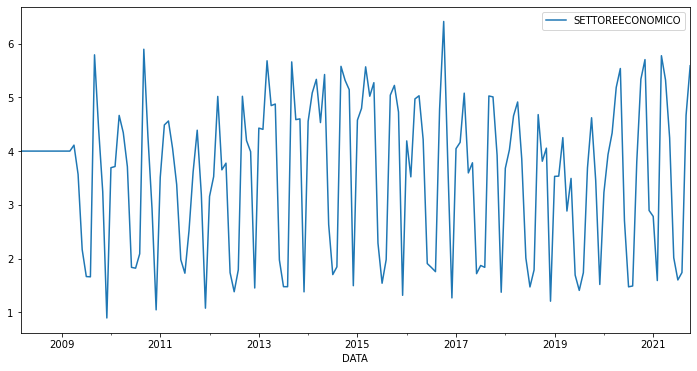

In [19]:
Assumptions_Sondrio.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

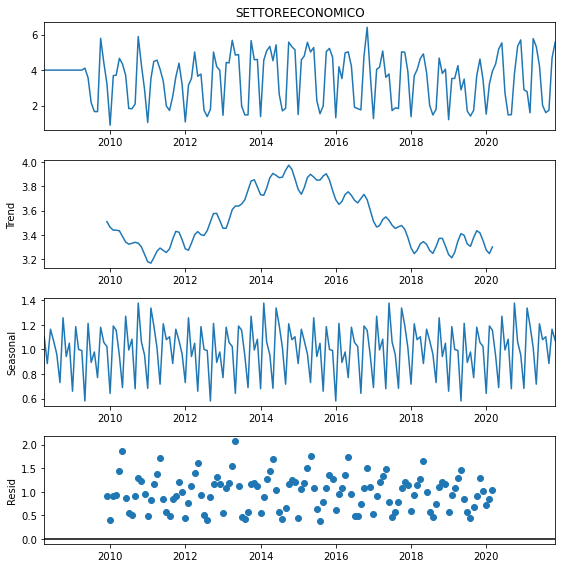

In [20]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul = seasonal_decompose(Assumptions_Sondrio['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

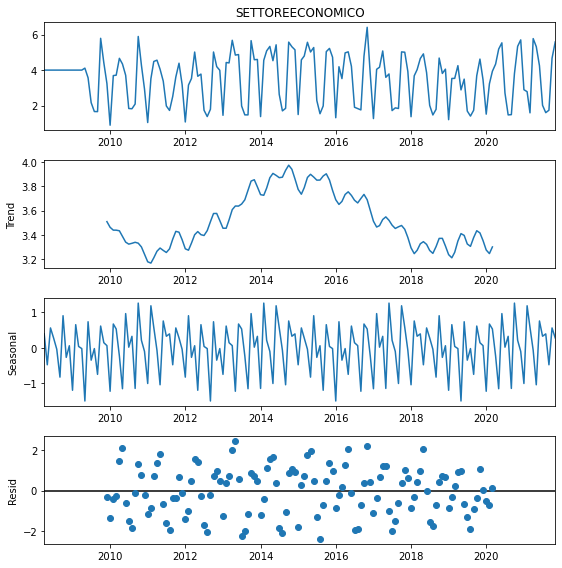

In [21]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Assumptions_Sondrio['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [22]:
# ADF calculation
p_value(Assumptions_Sondrio["SETTOREECONOMICO"])

ADF Statistic: -2.082575
p-value: 0.251579


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

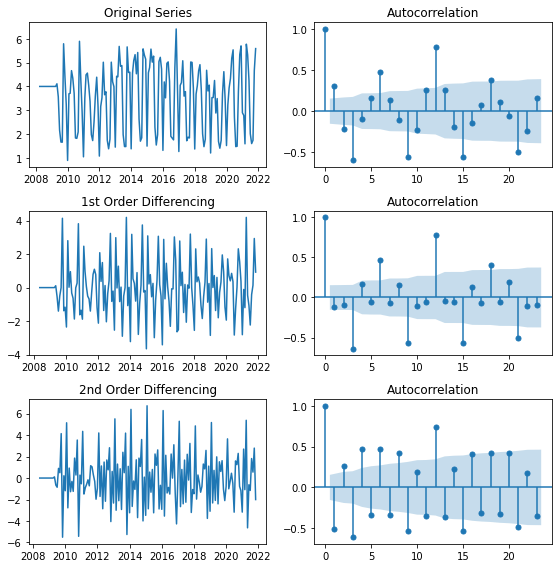

In [23]:
# Differencing plots representation
Differencing_Plot(Assumptions_Sondrio["SETTOREECONOMICO"])

In [24]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Assumptions_Sondrio["SETTOREECONOMICO"].diff())

ADF Statistic: -13.626590
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

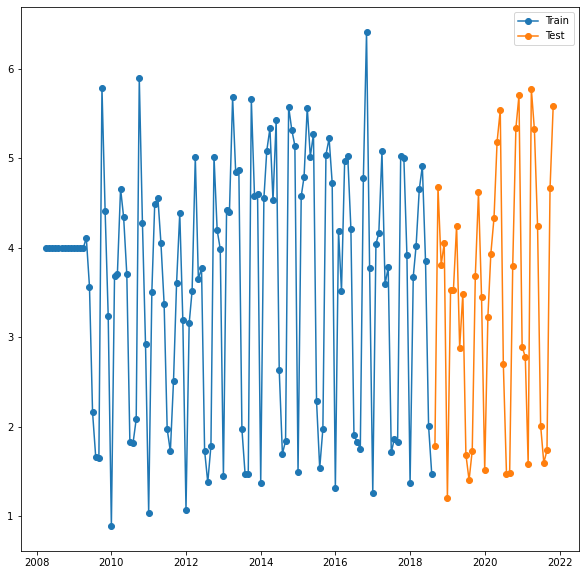

In [25]:
train, test = Dynamic_Splitting(Assumptions_Sondrio,"SETTOREECONOMICO",0.76)

## SARIMAX Model Creation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [26]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=290.383, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=309.569, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=286.520, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=247.056, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=256.667, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=248.381, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=247.526, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=253.089, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=247.388, Time=0.91 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=247.153, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=246.997, Time=0.13 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=257.734, Time=0.06 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=248.200, Time=0.22 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=247.239, Time=0.32 sec
 ARIMA(0,1,2)(1,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  125
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                -109.163
Date:                             Tue, 05 Jul 2022   AIC                            232.325
Time:                                     19:09:43   BIC                            251.355
Sample:                                          0   HQIC                           240.046
                                             - 125                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0971      0.120     -0.807      0.419      -0.333       0.139
ar.L2         -0.1952      0.112     -1.738      0.082      -0.415       0.025
ar.L3         -0.4367      0.087     -5.049      0.000      -0.606      -0.267
ma.L1         -0.6208      0.131     -4.744      0.000      -0.877      -0.364
ar.S.L12      -0.4108      0.124     -3.311      0.001      -0.654      -0.168
ar.S.L24      -0.3537      0.088     -4.011      0.000      -0.527      -0.181
sigma2         0.3898      0.047      8.224      0.000       0.297       0.483
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.99
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.37
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


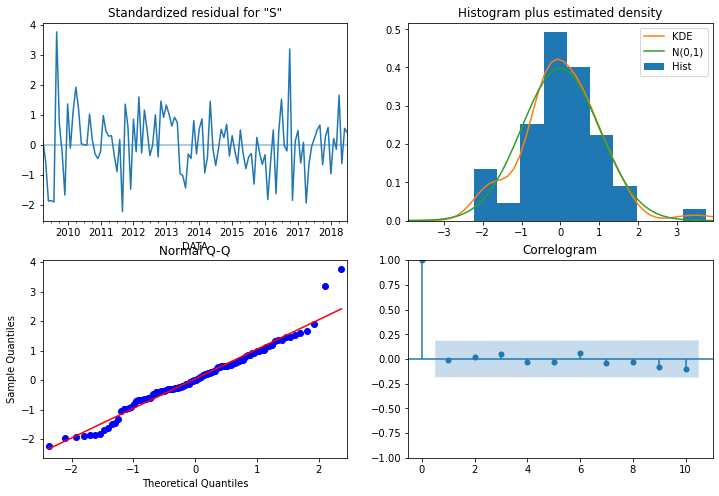

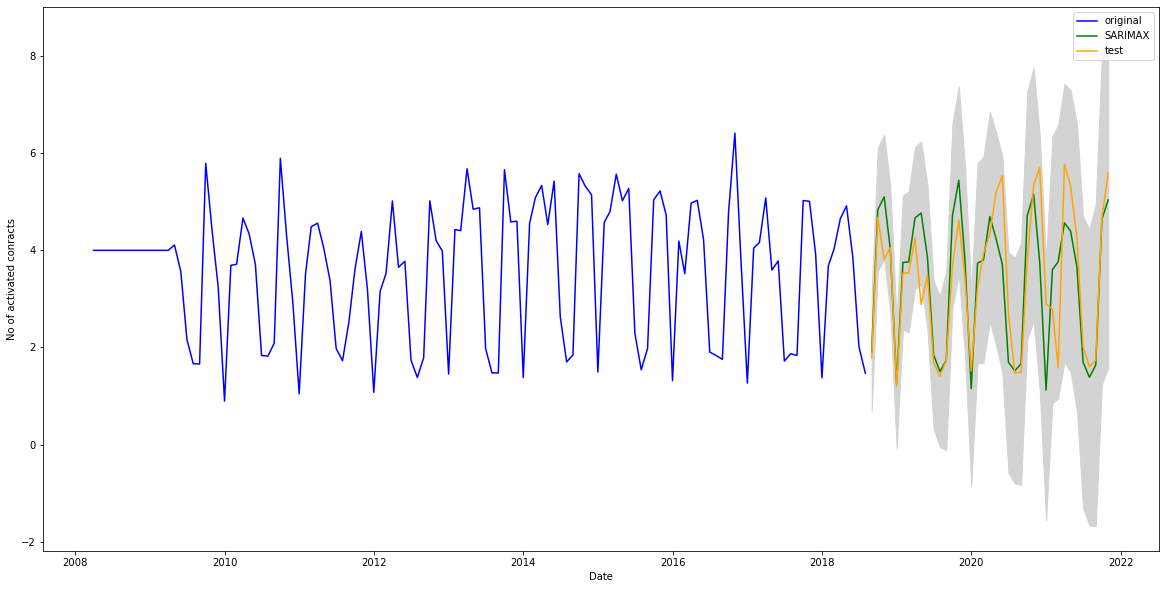

In [27]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",39,3,1,1,2,1,0,12)

In [28]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.872873


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Machine Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [30]:
Assumptions_Sondrio.head(), Assumptions_Sondrio.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0
 2008-06-30               4.0
 2008-07-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          2.014531
 2021-07-31          1.600619
 2021-08-31          1.738710
 2021-09-30          4.666667
 2021-10-31          5.589552)

In [31]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [32]:
scaled_train[:15]

array([[0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.58293813],
       [0.48432351]])

Elements contained in the 2 datasets are related in proportion to their value.

In [33]:
#Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [34]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.5628127 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127
 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127]
Prediction: 
[[0.5628127]]


In [35]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [36]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
#model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(LSTM(100, activation = 'tanh', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(generator, epochs = 200)  #Epochs = Number of Iterations

Epoch 1/200
113/113 [==============================] - 2s 3ms/step - loss: 0.0830
Epoch 2/200
113/113 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 3/200
113/113 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 4/200
113/113 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 5/200
113/113 [==============================] - 0s 3ms/step - loss: 0.0725
Epoch 6/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0633
Epoch 7/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0541
Epoch 8/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0450
Epoch 9/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0477
Epoch 10/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 11/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0464
Epoch 12/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 13/200


113/113 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 197/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 198/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 199/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 200/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0035


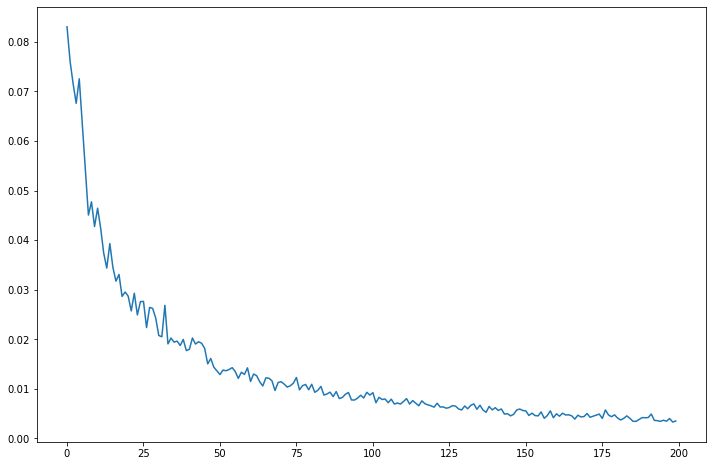

In [39]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [40]:
last_train_batch = scaled_train[-12:]

In [41]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 333ms/step


array([[0.17161986]], dtype=float32)

In [43]:
scaled_test[0]

array([0.16201687])

In [44]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [45]:
test_predictions

[array([0.17161986], dtype=float32),
 array([0.7107899], dtype=float32),
 array([0.876161], dtype=float32),
 array([0.51912016], dtype=float32),
 array([0.05052668], dtype=float32),
 array([0.55428904], dtype=float32),
 array([0.55975914], dtype=float32),
 array([0.72409725], dtype=float32),
 array([0.59071964], dtype=float32),
 array([0.58025706], dtype=float32),
 array([0.1903954], dtype=float32),
 array([0.1405791], dtype=float32),
 array([0.17189983], dtype=float32),
 array([0.72541916], dtype=float32),
 array([0.8106996], dtype=float32),
 array([0.5501075], dtype=float32),
 array([0.07014927], dtype=float32),
 array([0.5801215], dtype=float32),
 array([0.59561646], dtype=float32),
 array([0.7382754], dtype=float32),
 array([0.6537994], dtype=float32),
 array([0.6027521], dtype=float32),
 array([0.19766816], dtype=float32),
 array([0.13939124], dtype=float32),
 array([0.17839192], dtype=float32),
 array([0.76129854], dtype=float32),
 array([0.8147608], dtype=float32),
 array([0.559

In [46]:
test.head()

,SETTOREECONOMICO
DATA,
2018-08-31,1.787234
2018-09-30,4.679654
2018-10-31,3.811083
2018-11-30,4.054545
2018-12-31,1.205009


In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_3076/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [49]:
test.head()

,SETTOREECONOMICO,Predictions
DATA,,
2018-08-31,1.787234,1.840252
2018-09-30,4.679654,4.816972
2018-10-31,3.811083,5.729974
2018-11-30,4.054545,3.758777
2018-12-31,1.205009,1.171704


<AxesSubplot:xlabel='DATA'>

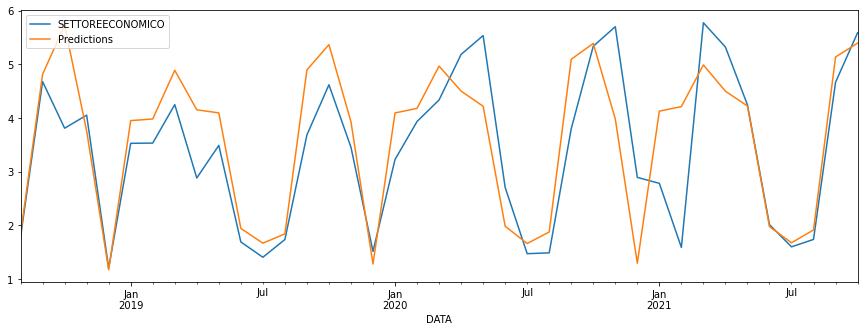

In [50]:
test.plot(figsize = (15,5))

In [51]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

0.886199741877334
